In [2]:
import os
import shutil
from os import listdir

import cv2

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Dropout, LSTM, Bidirectional, Dense, Activation
from tensorflow import keras
from keras import backend
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

### 1. Read the parase.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model

In [3]:
total_number_of_images = 20000

In [4]:
if not os.path.exists('images.csv'):
    counter = 0
    image_df = pd.DataFrame()
    with open('parser.txt', mode='r') as f:
        while counter < total_number_of_images:
            image_df = pd.concat([image_df, pd.DataFrame(f.readline().split()).T], axis=0)
            counter+=1
    image_df.to_csv('images.csv', index=False)
else:
    image_df = pd.read_csv('images.csv', index_col=0)

In [5]:
print(f"Shape of the image dataframe: {image_df.shape}")

Shape of the image dataframe: (20000, 2)


In [6]:
df = image_df.copy()

In [7]:
df.head()

,Status,Word
0,,
a01-000u-00-00,ok,A
a01-000u-00-01,ok,MOVE
a01-000u-00-02,ok,to
a01-000u-00-03,ok,stop
a01-000u-00-04,ok,Mr.


### EDA
1. Check for Null, NA or error

In [8]:
# Checkign the status counts
df['Status'].value_counts()

ok     17786
err     2214
Name: Status, dtype: int64

In [9]:
# Remove the images with err status

df = df.drop(df[df['Status'] == 'err'].index, axis=0)
print(f'Shape of the datafram after dropping error: {df.shape}')

Shape of the datafram after dropping error: (17786, 2)


In [10]:
# Picking up 12k images for training, validation and testing
df = df.sample(12000)
print(f'Shape of the datafram after Sampling: {df.shape}')

Shape of the datafram after Sampling: (12000, 2)


In [11]:
# Check for null, or empty characters
result = df['Word'].isna().any()
print(f'Are there any null words: {result}')

result = df[df['Word'].str.len() == 0].any()
print(f'Are there any empty words: {result}')

Are there any null words: False
Are there any empty words: Status    False
Word      False
dtype: bool


In [12]:
# Drop of Status columns
if 'Status' in df.columns:
    df = df.drop(columns=['Status'], axis=1)
df.head()

,Word
0,
a01-132-06-01,-
a05-017-03-00,While
a01-030x-06-00,Labour's
a02-086-03-01,Roy
a05-099-02-01,Mr.


In [13]:
# Get the length of the word
df['Word'] = df['Word'].str.strip()
df['Word_Length'] = df['Word'].str.len()
df.head()

,Word,Word_Length
0,,
a01-132-06-01,-,1
a05-017-03-00,While,5
a01-030x-06-00,Labour's,8
a02-086-03-01,Roy,3
a05-099-02-01,Mr.,3


In [14]:
# copy the images to a particular folder if it is empty

source_path = 'words\words'
dest_path = 'dataset'

if len(listdir(dest_path)) != total_number_of_images:

    for image_id in df.index.values:
        metadata = image_id.split('-')
        folder = metadata[0]
        sub_folder = folder+'-'+metadata[1]
        file_name = image_id+'.png'
        full_path = os.path.join(source_path, folder, sub_folder, file_name)
        shutil.copyfile(full_path, os.path.join(dest_path, file_name))
else:
    print('This path already has all the files')

This path already has all the files


### 2. Images can be of different shape thus resize all your images to have same shape (for example = (128, 32))

In [15]:
df['Image_Path'] = dest_path+'\\'+ df.index+'.png'
df.head()

,Word,Word_Length,Image_Path
0,,,
a01-132-06-01,-,1,dataset\a01-132-06-01.png
a05-017-03-00,While,5,dataset\a05-017-03-00.png
a01-030x-06-00,Labour's,8,dataset\a01-030x-06-00.png
a02-086-03-01,Roy,3,dataset\a02-086-03-01.png
a05-099-02-01,Mr.,3,dataset\a05-099-02-01.png


In [16]:
# Load the images to a dataset

In [17]:
df['Image'] = None
df.head()

,Word,Word_Length,Image_Path,Image
0,,,,
a01-132-06-01,-,1,dataset\a01-132-06-01.png,None
a05-017-03-00,While,5,dataset\a05-017-03-00.png,None
a01-030x-06-00,Labour's,8,dataset\a01-030x-06-00.png,None
a02-086-03-01,Roy,3,dataset\a02-086-03-01.png,None
a05-099-02-01,Mr.,3,dataset\a05-099-02-01.png,None


In [18]:
Images = []
image_shape = (128, 32)
for index in df.index:
    image_path = df.at[index, 'Image_Path']
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is not None:
        try:
            result = cv2.resize(image, image_shape)
            result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)
        except Exception as e:
            result = np.zeros(image_shape)
    else:
        result = np.zeros(image_shape)
        print(f'Failed to load Image{image_path}')
    Images.append(result)
    df.at[index, 'Image'] = result

Failed to load Imagedataset\a01-117-05-02.png


In [19]:
Images = np.array(Images)
print(f'Shape of Images: {Images.shape}')

Shape of Images: (12000, 128, 32)


In [20]:
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res 

In [21]:
df['Image'].apply(lambda x: prod(x.shape)).min()

4096

In [42]:
df = df.reset_index(drop=True)
df.head()

,Word,Word_Length,Image_Path,Image,Image_Scaled,target
0,-,1,dataset\a01-132-06-01.png,"[[244, 244, 233, 219, 204, 189, 173, 156, 139,...","[[0.9568627450980393, 0.9568627450980393, 0.91...","[8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
1,While,5,dataset\a05-017-03-00.png,"[[255, 255, 250, 247, 246, 244, 248, 250, 247,...","[[1.0, 1.0, 0.9803921568627451, 0.968627450980...","[46, 57, 58, 61, 54, -1, -1, -1, -1, -1, -1, -..."
2,Labour's,8,dataset\a01-030x-06-00.png,"[[244, 240, 211, 61, 49, 86, 163, 217, 237, 24...","[[0.9568627450980393, 0.9411764705882353, 0.82...","[35, 50, 51, 64, 70, 67, 3, 68, -1, -1, -1, -1..."
3,Roy,3,dataset\a02-086-03-01.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[41, 64, 74, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,Mr.,3,dataset\a05-099-02-01.png,"[[242, 240, 238, 232, 229, 235, 240, 238, 237,...","[[0.9490196078431372, 0.9411764705882353, 0.93...","[36, 67, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1..."


In [43]:
def show_image(image):
    plt.imshow(image)
    plt.show()

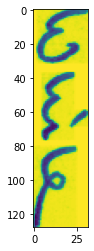

In [44]:
show_image(df['Image'][1])

### 3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1 

In [45]:
df['Image_Scaled'] = df['Image'] / 255.
Images = Images / 255.
df.head()

,Word,Word_Length,Image_Path,Image,Image_Scaled,target
0,-,1,dataset\a01-132-06-01.png,"[[244, 244, 233, 219, 204, 189, 173, 156, 139,...","[[0.9568627450980393, 0.9568627450980393, 0.91...","[8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
1,While,5,dataset\a05-017-03-00.png,"[[255, 255, 250, 247, 246, 244, 248, 250, 247,...","[[1.0, 1.0, 0.9803921568627451, 0.968627450980...","[46, 57, 58, 61, 54, -1, -1, -1, -1, -1, -1, -..."
2,Labour's,8,dataset\a01-030x-06-00.png,"[[244, 240, 211, 61, 49, 86, 163, 217, 237, 24...","[[0.9568627450980393, 0.9411764705882353, 0.82...","[35, 50, 51, 64, 70, 67, 3, 68, -1, -1, -1, -1..."
3,Roy,3,dataset\a02-086-03-01.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[41, 64, 74, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,Mr.,3,dataset\a05-099-02-01.png,"[[242, 240, 238, 232, 229, 235, 240, 238, 237,...","[[0.9490196078431372, 0.9411764705882353, 0.93...","[36, 67, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1..."


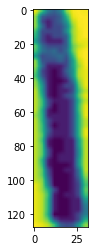

In [46]:
show_image(df['Image'][0])

### 4. Create a list of all characters and use the characters's index to encode the actual words into digits

In [47]:
vocabulary = sorted(list(set(''.join(df['Word']))))
char_to_number_dict = dict(zip(vocabulary, range(len(vocabulary))))
number_to_char_dict = dict(zip(range(len(vocabulary)), vocabulary))
characters = list(vocabulary)
characters_length = len(characters)
print(f'Characters : {characters[:10]}')
print(f'Total number of characters: {characters_length}')

Characters : ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.']
Total number of characters: 76


In [48]:
le = LabelEncoder()
le.fit(characters)

LabelEncoder()

In [49]:
le.transform(['A','B'])

array([24, 25], dtype=int64)

### 5. Pad all the words to have a similar length

In [50]:
# Finding the maximum length of a word
maximum_word_length = df['Word'].str.len().max()
print(maximum_word_length)

16


In [51]:
def transform_word_to_array(word):
    if not word:
        return np.ones(maximum_word_length) * -1
    
    word_char = le.transform(list(word))
    result = np.pad(word_char, (0, maximum_word_length - len(word_char)), 'constant', constant_values=(0, -1))
    return result

In [52]:
# Testing couple of words
print(transform_word_to_array('python'))
print(transform_word_to_array('Python'))
print(transform_word_to_array(None))

[65 74 69 57 64 63 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[39 74 69 57 64 63 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [53]:
df['target'] = df['Word'].apply(transform_word_to_array)
df.head()

,Word,Word_Length,Image_Path,Image,Image_Scaled,target
0,-,1,dataset\a01-132-06-01.png,"[[244, 244, 233, 219, 204, 189, 173, 156, 139,...","[[0.9568627450980393, 0.9568627450980393, 0.91...","[8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
1,While,5,dataset\a05-017-03-00.png,"[[255, 255, 250, 247, 246, 244, 248, 250, 247,...","[[1.0, 1.0, 0.9803921568627451, 0.968627450980...","[46, 57, 58, 61, 54, -1, -1, -1, -1, -1, -1, -..."
2,Labour's,8,dataset\a01-030x-06-00.png,"[[244, 240, 211, 61, 49, 86, 163, 217, 237, 24...","[[0.9568627450980393, 0.9411764705882353, 0.82...","[35, 50, 51, 64, 70, 67, 3, 68, -1, -1, -1, -1..."
3,Roy,3,dataset\a02-086-03-01.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[41, 64, 74, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,Mr.,3,dataset\a05-099-02-01.png,"[[242, 240, 238, 232, 229, 235, 240, 238, 237,...","[[0.9490196078431372, 0.9411764705882353, 0.93...","[36, 67, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1..."


In [54]:
# Resetting index to access Images array
#df = df.reset_index().drop(columns=['0'])
df.head()

,Word,Word_Length,Image_Path,Image,Image_Scaled,target
0,-,1,dataset\a01-132-06-01.png,"[[244, 244, 233, 219, 204, 189, 173, 156, 139,...","[[0.9568627450980393, 0.9568627450980393, 0.91...","[8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1..."
1,While,5,dataset\a05-017-03-00.png,"[[255, 255, 250, 247, 246, 244, 248, 250, 247,...","[[1.0, 1.0, 0.9803921568627451, 0.968627450980...","[46, 57, 58, 61, 54, -1, -1, -1, -1, -1, -1, -..."
2,Labour's,8,dataset\a01-030x-06-00.png,"[[244, 240, 211, 61, 49, 86, 163, 217, 237, 24...","[[0.9568627450980393, 0.9411764705882353, 0.82...","[35, 50, 51, 64, 70, 67, 3, 68, -1, -1, -1, -1..."
3,Roy,3,dataset\a02-086-03-01.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[41, 64, 74, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,Mr.,3,dataset\a05-099-02-01.png,"[[242, 240, 238, 232, 229, 235, 240, 238, 237,...","[[0.9490196078431372, 0.9411764705882353, 0.93...","[36, 67, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1..."


### 6. Split your dataset for training, validation and testing

In [55]:
# Splitting dataset into training and valid 11k, 1k

X_df, X_valid_df, y, y_valid = train_test_split(df[['Word', 'Word_Length', 'Image_Scaled']], 
                                                      np.array(df['target'].to_list()), 
                                                      test_size=0.0833, 
                                                      random_state=42)
print(f'Shape of X_train is {X_df.shape}')
print(f'Shape of X_test is {X_valid_df.shape}')
print(f'Shape of y_train is {y.shape}')
print(f'Shape of y_test is {y_valid.shape}')

Shape of X_train is (11000, 3)
Shape of X_test is (1000, 3)
Shape of y_train is (11000, 16)
Shape of y_test is (1000, 16)


In [56]:
# Splitting dataset into training and test 10k, 2k

X_train_df, X_test_df, y_train, y_test = train_test_split(X_df, y, test_size=0.1818, random_state=42)
print(f'Shape of X_train is {X_train_df.shape}')
print(f'Shape of X_test is {X_test_df.shape}')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of X_train is (9000, 3)
Shape of X_test is (2000, 3)
Shape of y_train is (9000, 16)
Shape of y_test is (2000, 16)


In [58]:
X_train = Images[X_train_df.index]

X_valid = Images[X_valid_df.index]

X_test = Images[X_test_df.index]

print(f'Shape of X_train is {X_train.shape}')
print(f'Shape of y_train is {y_train.shape}')
print(f'Shape of X_valid is {X_valid.shape}')
print(f'Shape of y_valid is {y_valid.shape}')
print(f'Shape of X_test is {X_test.shape}')
print(f'Shape of y_test is {y_test.shape}')

Shape of X_train is (9000, 128, 32)
Shape of y_train is (9000, 16)
Shape of X_valid is (1000, 128, 32)
Shape of y_valid is (1000, 16)
Shape of X_test is (2000, 128, 32)
Shape of y_test is (2000, 16)


In [59]:
# This is for debugging
#print(df['Image'].apply(lambda x: prod(x.shape)).min())
#print(df['target'].apply(lambda x: prod(x.shape)).max())

In [60]:
target = []
for value in df['target'].to_numpy():
    target.append(value)
target = np.array(target)
print(target.shape)

(12000, 16)


In [61]:
X_train.shape, y_train.shape

((9000, 128, 32), (9000, 16))

### 7. Create a model for training:
a) Add several CNN layers to extract the sequence of features

b) Add Bi-LSTM layers to propagate through the sequence

c) Add a dense layer (output layer) with total number of neurons as (total number of 
characters + 1) and the activation as softmax.

In [62]:
optimizer_name = 'Adam'
image_width, image_height = X_train[0].shape[0], X_train[0].shape[1]
input_img = keras.Input(shape=(image_width, image_height, 1), name = 'input_image')
labels = keras.layers.Input(name='label', shape=(None, ))

x = keras.layers.Conv2D(32,
                       (3,3),
                       activation='relu',
                       kernel_initializer='he_normal',
                        padding='same',
                        name='Conv1')(input_img)
x = keras.layers.MaxPool2D((2,2), name='pool1')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(64, 
                       (3,3),
                       activation='relu',
                       kernel_initializer = 'he_normal',
                       padding='same',
                       name='Conv2')(x)
x = keras.layers.MaxPool2D((2,2), name='pool2')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 
                       (3,3),
                       activation='relu',
                       kernel_initializer = 'he_normal',
                       padding='same',
                       name='Conv3')(x)
x = keras.layers.MaxPool2D((1,2), name='pool3')(x)
x = keras.layers.BatchNormalization()(x)

new_shape = ((image_width // 4) , (image_height // 4) * 64)

x = keras.layers.Reshape(target_shape = new_shape, name = 'reshape')(x)
x = keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', name = 'dense1')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
)(x)

x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
)(x)

x = keras.layers.Dense(
    characters_length + 2, name='dense2', kernel_initializer='he_normal'
)(x)
    
y_pred = Activation('softmax', name='softmax')(x)    
model = keras.Model(inputs = input_img, outputs = y_pred)    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 16, 32)        128       
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 8, 64)         256   

In [63]:
train_size = X_train.shape[0]
print(f'train_size: {train_size}')

valid_size = X_valid.shape[0]
print(f'valid_size: {valid_size}')

train_size: 9000
valid_size: 1000


In [64]:
num_of_timestamps = 32
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1])*(num_of_timestamps - 2)
train_output = np.zeros([train_size])
for i in range(y_train.shape[0]):
    train_label_len[i] = len([x for x in y_train[i] if x > -1])    

In [65]:
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1])*(num_of_timestamps - 2)
valid_output = np.zeros([valid_size])
for i in range(y_valid.shape[0]):
    valid_label_len[i] = len([x for x in y_valid[i] if x > -1])

In [66]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    print(y_pred)
    y_pred = y_pred[:, 2:, :]
    return backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

### 8. The out sequence from the output layer will be fed to the CTC layer. 

In [67]:
labels = keras.Input(name='gtruth_labels', shape=[maximum_word_length], dtype='float32')
input_length = keras.Input(name='input_length', shape=[1], dtype='int64')
label_length = keras.Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = layers.Lambda(ctc_lambda_func, output_shape = (1, ), name='ctc')([y_pred, labels, input_length, label_length])
model_final = keras.Model(inputs=[input_img, labels, input_length, label_length], outputs = ctc_loss)

Tensor("Placeholder:0", shape=(None, 32, 78), dtype=float32)


In [ ]:
# Train out model
model_final.save('model.h5')
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=keras.optimizers.Adam())

model_final.fit(x=[X_train, y_train, train_input_len, train_label_len], 
                y= train_output,
                validation_data=([X_valid, y_valid, valid_input_len, valid_label_len],
                valid_output),
                epochs=10)

Epoch 1/10
Tensor("model_1/softmax/Softmax:0", shape=(None, 32, 78), dtype=float32)
Tensor("model_1/softmax/Softmax:0", shape=(None, 32, 78), dtype=float32)
282/282 [==============================] - 105s 337ms/step - loss: 11.7808 - val_loss: 36.1420
Epoch 2/10
102/282 [=========>....................] - ETA: 53s - loss: 10.2184

In [70]:
def num_to_label(num):
    return [number_to_char_dict[x] for x in num if x > -1]

In [71]:
# Check the performance
preds = model.predict(X_valid)
decoded = backend.get_value(backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [72]:
y_true = X_valid_df['Word'].to_numpy()
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 0.00%
Correct words predicted      : 0.00%


### 9. Predict output using your model(do not use the last loss layer) on validation images, use ctc_decode to decode your output and then print the actual words using the indexes from your character's list.

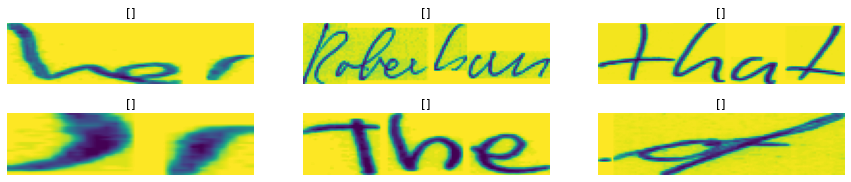

In [73]:
test = X_test_df
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image = test.iloc[i, -1]
    plt.imshow(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    pred = model.predict(image.reshape(1, 128, 32, 1))
    decoded = backend.get_value(backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [451]:
X_test_df.head()

,Word,Word_Length,Image_Scaled
6032,revealed,8,"[[1.0, 1.0, 1.0, 1.0, 1.0, 0.996078431372549, ..."
3367,white-faced,11,"[[1.0, 0.8980392156862745, 0.23137254901960785..."
10607,territory,9,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
654,plan,4,"[[1.0, 1.0, 0.9686274509803922, 1.0, 1.0, 0.98..."
9615,involved,8,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


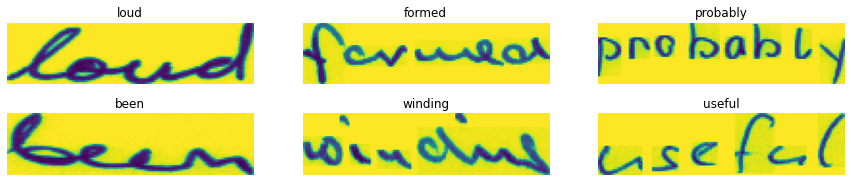

In [466]:
test = X_train_df
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image = test.iloc[i, -1]
    plt.imshow(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    
    plt.title(test.iloc[i, 0], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)